<a href="https://colab.research.google.com/github/Tuesdaythe13th/AI-Model-Taxonomy/blob/main/Estimating_elasticity_of_substitution_%5Bnotebook_for_Epoch_AI_newsletter%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accompanying notebook for [The economic consequences of automating remote work](https://epoch.ai/gradient-updates/consequences-of-automating-remote-work).

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

###############################################################################
# 1. CES-related functions
###############################################################################
def ces_production_function(R, N, alpha, rho, A=1.0):
    """
    Computes CES production given R, N, alpha, rho, and A.
    Y = A * [alpha * R^rho + (1-alpha)* N^rho]^(1/rho)
    """
    return A * (alpha * (R ** rho) + (1 - alpha) * (N ** rho)) ** (1.0 / rho)


def fit_ces_parameters(data):
    """
    Expects a DataFrame 'data' with columns: ['R', 'N', 'Y'].
    We'll fit alpha, rho, and then solve for A by minimizing MSE in log-space.
    """
    def objective(params):
        alpha, rho = params
        # Penalize out-of-bounds alpha
        if alpha <= 0 or alpha >= 1:
            return 1e10

        # We'll fix A=1 in the objective, then solve for A afterward
        pred_logY = []
        for idx, row in data.iterrows():
            R, N, Y_obs = row["R"], row["N"], row["Y"]
            # Penalize invalid or zero inputs
            if R <= 0 or N <= 0 or Y_obs <= 0:
                return 1e10
            Y_pred = ces_production_function(R, N, alpha, rho, A=1.0)
            pred_logY.append(np.log(Y_pred))

        pred_logY = np.array(pred_logY)
        actual_logY = np.log(data["Y"].values)
        return np.mean((pred_logY - actual_logY)**2)

    initial_guess = [0.5, 0.5]
    # alpha in (0,1), rho < 1 (so elasticity isn't infinite by default)
    bounds = [(1e-6, 1 - 1e-6), (-0.999, 0.999)]
    result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)
    alpha_hat, rho_hat = result.x

    # Now solve for A
    R_data = data["R"].values
    N_data = data["N"].values
    Y_data = data["Y"].values
    combined_term = alpha_hat * (R_data ** rho_hat) + (1 - alpha_hat) * (N_data ** rho_hat)

    A_vals = []
    for y_i, c_i in zip(Y_data, combined_term):
        A_vals.append(y_i / (c_i ** (1.0/rho_hat)))
    A_hat = np.mean(A_vals)

    return alpha_hat, rho_hat, A_hat


###############################################################################
# 2. Load and resample GDP (quarterly) to yearly
###############################################################################
# The file GDPC1.csv has columns: ["observation_date", "GDPC1"]
gdpc1_url = "https://epoch.ai/data/estimating-elasticity-of-substitution/GDPC1-2024-01-10.csv"
df_gdp = pd.read_csv(gdpc1_url, parse_dates=["observation_date"])
df_gdp.rename(columns={"observation_date": "date", "GDPC1": "real_gdp_bln"}, inplace=True)
df_gdp.set_index("date", inplace=True)

# Convert quarterly -> yearly. We'll take the average of the four quarters.
df_gdp_yearly = df_gdp.resample("YE-DEC").mean()
# "YE-DEC" means "annual frequency, year ending in December."


###############################################################################
# 3. Load and resample labor force (monthly) to yearly
###############################################################################
# The file CLF16OV.csv has columns: ["observation_date", "CLF16OV"]
clf160v_url = "https://epoch.ai/data/estimating-elasticity-of-substitution/CLF16OV-2024-01-10.csv"
df_labor = pd.read_csv(clf160v_url, parse_dates=["observation_date"])
df_labor.rename(columns={"observation_date": "date",
                         "CLF16OV": "labor_force_thousands"}, inplace=True)
df_labor.set_index("date", inplace=True)

# Convert monthly -> yearly, again using average
df_labor_yearly = df_labor.resample("YE-DEC").mean()


###############################################################################
# 4. Create a DataFrame for the annual remote fraction (already yearly).
###############################################################################
annual_remote_fraction = {
    2008: 0.041,
    2009: 0.043,
    2010: 0.043,
    2011: 0.043,
    2012: 0.044,
    2013: 0.044,
    2014: 0.045,
    2015: 0.046,
    2016: 0.050,
    2017: 0.052,
    2018: 0.053,
    2019: 0.057,
    2020: 0.360,
    2021: 0.179,
    2022: 0.140,
    # Data taken from Kevin Drum (https://jabberwocking.com/heres-a-midterm-report-on-remote-work/)
}
df_remote_annual = pd.DataFrame(
    list(annual_remote_fraction.items()),
    columns=["year", "remote_fraction"]
)
df_remote_annual["date"] = pd.to_datetime(df_remote_annual["year"].astype(str) + "-12-31")
# We'll index on December 31 of each year, so it aligns with "YE-DEC" annual freq
df_remote_annual.set_index("date", inplace=True)
df_remote_annual.drop(columns="year", inplace=True)
df_remote_annual.sort_index(inplace=True)
# This data is already yearly, so no resampling needed.


###############################################################################
# 5. Merge all data into a single yearly DataFrame
###############################################################################
df_main = df_gdp_yearly.join(df_labor_yearly, how="inner").join(df_remote_annual, how="inner")

# Now we have something like:
# date (year end) | real_gdp_bln | labor_force_thousands | remote_fraction


###############################################################################
# 6. Construct R, N, Y columns for the CES function
###############################################################################
df_main["R"] = df_main["remote_fraction"] * df_main["labor_force_thousands"]
df_main["N"] = (1 - df_main["remote_fraction"]) * df_main["labor_force_thousands"]
df_main["Y"] = df_main["real_gdp_bln"]  # or scale as needed (e.g. / 1000 to get trillions)

# Drop any years that are missing data
df_main = df_main.dropna(subset=["R", "N", "Y"])


###############################################################################
# 7. Fit the CES model and print results
###############################################################################
alpha_hat, rho_hat, A_hat = fit_ces_parameters(df_main)

print("Estimated alpha =", alpha_hat)
print("Estimated rho =", rho_hat)
print("Estimated A =", A_hat)

# Compute elasticity if not near rho=1
if abs(rho_hat - 1.0) < 1e-2:
    print("Elasticity of substitution is effectively infinite (rho ~ 1).")
else:
    sigma_hat = 1.0 / (1.0 - rho_hat)
    print("Elasticity of substitution =", sigma_hat)

Estimated alpha = 0.9193548203544041
Estimated rho = 0.922477364585519
Estimated A = 0.9430732308974308
Elasticity of substitution = 12.899458263427443


Plot saved as yearly_data_plot.svg


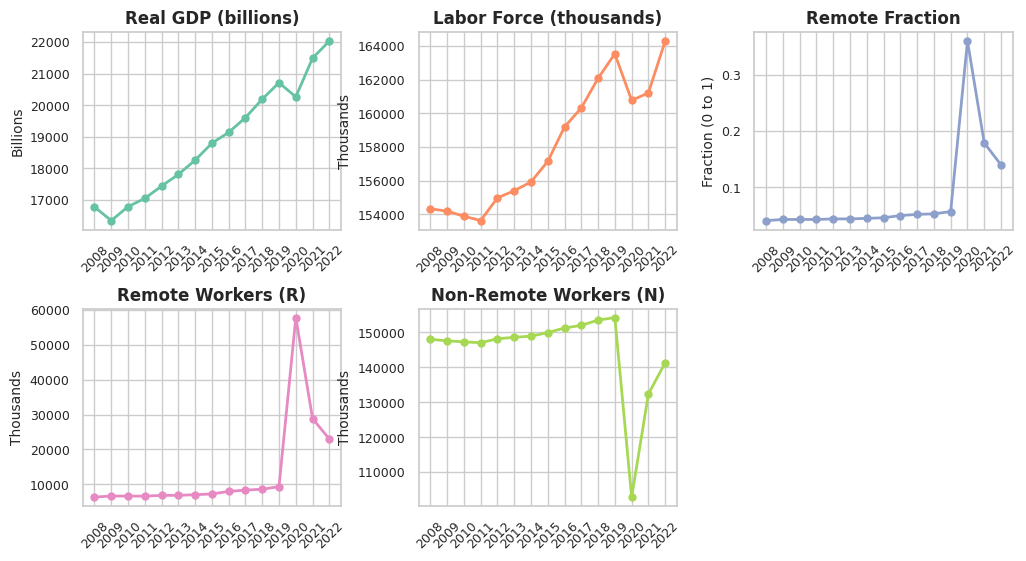

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_yearly_data(df_main, output_file="plot.svg"):
    """
    Plots:
      1) Real GDP (billions)
      2) Labor Force (thousands)
      3) Remote Fraction
      4) Remote Workers (R)
      5) Non-Remote Workers (N)
    in a 2x3 grid of subplots.

    df_main should be annual data with a DatetimeIndex (e.g., 2008-12-31, 2009-12-31, etc.).
    Columns needed: ['real_gdp_bln', 'labor_force_thousands', 'remote_fraction', 'R', 'N'].

    Saves the resulting plot as an SVG to the specified output_file.
    """

    # Use a whitegrid style but smaller font context than 'talk'
    sns.set_theme(style="whitegrid", context="notebook")

    # Make figure and axes: 2 rows, 3 cols
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), sharex=False)
    axs = axs.flatten()

    # We'll define each subplot: (column_name, title, y_label)
    plot_specs = [
        ("real_gdp_bln",        "Real GDP (billions)",        "Billions"),
        ("labor_force_thousands","Labor Force (thousands)",    "Thousands"),
        ("remote_fraction",     "Remote Fraction",            "Fraction (0 to 1)"),
        ("R",                   "Remote Workers (R)",         "Thousands"),
        ("N",                   "Non-Remote Workers (N)",     "Thousands"),
    ]

    # Color palette
    colors = sns.color_palette("Set2", len(plot_specs))

    # For convenience, let's make a list of just the years for ticks
    years = df_main.index.year.unique()

    # Plot each variable
    for i, (col, title, ylabel) in enumerate(plot_specs):
        ax = axs[i]

        ax.plot(
            df_main.index,
            df_main[col],
            color=colors[i],
            marker='o',
            markersize=5,
            linewidth=2
        )
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=10)

        # Set x-ticks exactly at each year in the dataset
        ax.set_xticks(df_main.index)
        # Convert to year labels only
        ax.set_xticklabels([str(x) for x in df_main.index.year], rotation=45)

        # Slightly smaller tick labels
        ax.tick_params(axis='x', labelsize=9)
        ax.tick_params(axis='y', labelsize=9)

    # Hide the last subplot if we only have 5 variables
    if len(axs) > len(plot_specs):
        axs[-1].axis("off")

    # Reduce whitespace between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.4, top=0.90)

    # Save the plot as an SVG file
    plt.savefig(output_file, format="svg")
    print(f"Plot saved as {output_file}")

# Example usage:
plot_yearly_data(df_main, output_file="yearly_data_plot.svg")

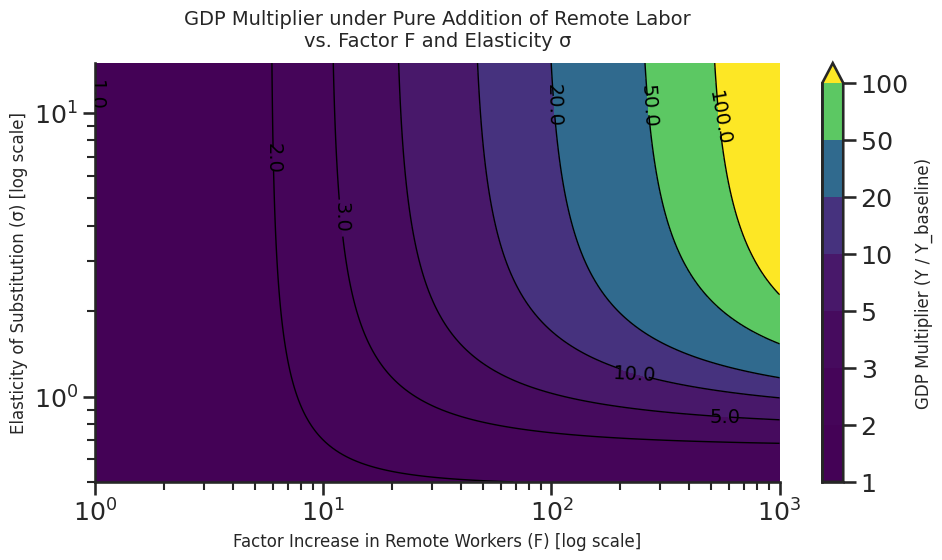

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gdp_multiplier_contours():
    """
    2D contour plot (log-log axes) for the GDP multiplier = Y_new / Y_baseline.
    Now with larger contour labels and improved contrast.
    """

    # -------------------------------------------------------------------------
    # 1) Basic CES scenario parameters
    # -------------------------------------------------------------------------
    A = 1.0
    alpha = 0.34
    R0 = 1.0
    N0 = 2.0

    # Factor F in [1, 1000], on a log scale
    F_min, F_max = 1.0, 1000.0
    n_F = 200
    F_values = np.logspace(np.log10(F_min), np.log10(F_max), n_F)

    # Elasticity sigma in [0.8, 100], also on a log scale
    sigma_min, sigma_max = 0.5, 15.0
    n_sigma = 200
    sigma_values = np.logspace(np.log10(sigma_min), np.log10(sigma_max), n_sigma)

    # -------------------------------------------------------------------------
    # 2) CES output functions (pure addition of remote workers)
    # -------------------------------------------------------------------------
    def ces_output(F, sigma):
        rho = 1.0 - 1.0/sigma
        remote_part = alpha * (F * R0) ** rho
        nonrem_part = (1 - alpha) * (N0 ** rho)
        return A * (remote_part + nonrem_part) ** (1.0 / rho)

    def ces_baseline(sigma):
        rho = 1.0 - 1.0/sigma
        remote_base = alpha * (R0 ** rho)
        nonrem_base = (1 - alpha) * (N0 ** rho)
        return A * (remote_base + nonrem_base) ** (1.0 / rho)

    # -------------------------------------------------------------------------
    # 3) Build the 2D mesh and compute the GDP multiplier
    # -------------------------------------------------------------------------
    X, Y = np.meshgrid(F_values, sigma_values)  # X=F, Y=sigma
    Z = np.zeros_like(X)

    for i in range(n_sigma):
        for j in range(n_F):
            s = Y[i, j]
            f = X[i, j]
            Z[i, j] = ces_output(f, s) / ces_baseline(s)  # multiplier

    # -------------------------------------------------------------------------
    # 4) Plot with a new colormap and bigger label fonts
    # -------------------------------------------------------------------------
    sns.set_theme(style="ticks", context="talk", font_scale=1.1)
    fig, ax = plt.subplots(figsize=(10, 6))

    # Contour levels from 0.5 up to 100
    levels = [1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0]

    # Use a colormap that avoids bright yellows, for instance "magma" or "viridis"
    contour_filled = ax.contourf(X, Y, Z, levels=levels, cmap="viridis", extend="max")

    # Draw black contour lines; label in black with bigger font
    contour_lines = ax.contour(X, Y, Z, levels=levels, colors="black", linewidths=1)
    ax.clabel(contour_lines, inline=True, fmt="%.1f", fontsize=14, colors="black")

    # Colorbar
    cbar = plt.colorbar(contour_filled, ax=ax)
    cbar.set_label("GDP Multiplier (Y / Y_baseline)", fontsize=12)

    # Log scales on both axes
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlabel("Factor Increase in Remote Workers (F) [log scale]", fontsize=12)
    ax.set_ylabel("Elasticity of Substitution (σ) [log scale]", fontsize=12)
    ax.set_title("GDP Multiplier under Pure Addition of Remote Labor\nvs. Factor F and Elasticity σ",
                 fontsize=14, pad=12)

    sns.despine()  # remove top/right spines for a 'ticks' style
    plt.tight_layout()
    plt.show()


# Example usage:
if __name__ == "__main__":
    plot_gdp_multiplier_contours()

<ipython-input-5-554d610d1fb6>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plot saved to pessimistic_optimistic_scenarios.svg


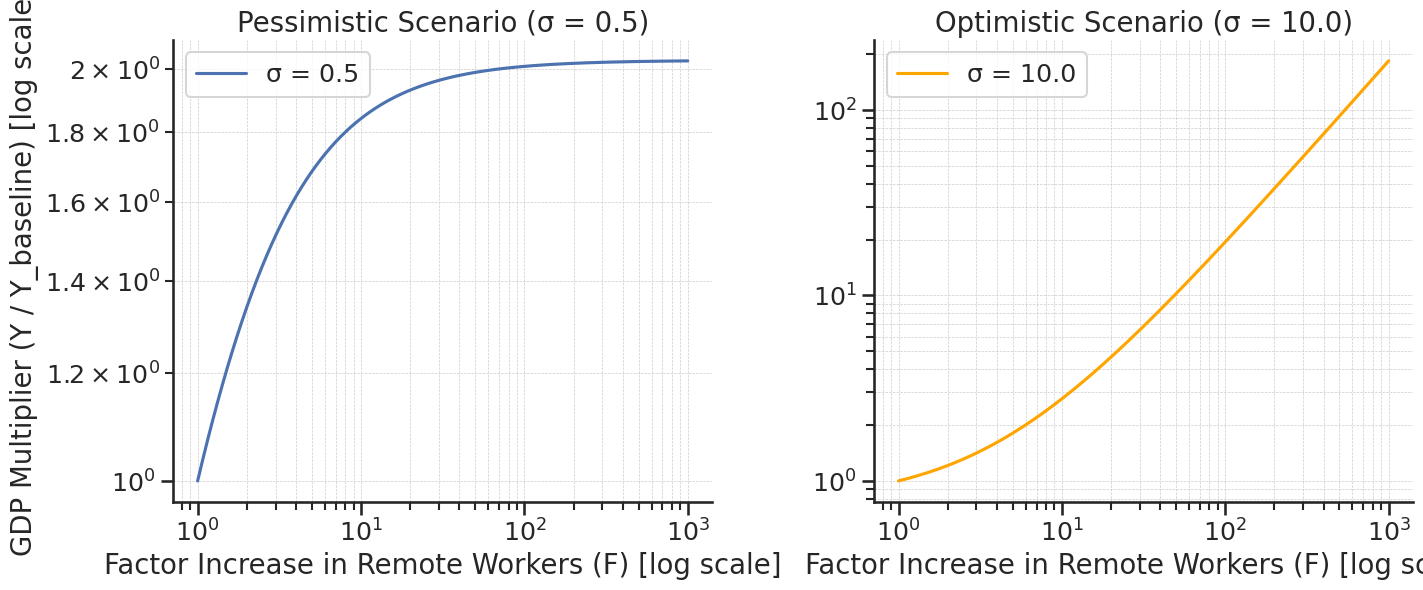

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pessimistic_optimistic_scenarios_svg(output_path="pessimistic_optimistic_scenarios.svg"):
    """
    Create side-by-side contour plots for "Pessimistic" (σ=0.5)
    and "Optimistic" (σ=10.0) scenarios and export to an SVG file.
    """
    # -------------------------------------------------------------------------
    # Basic CES scenario parameters
    # -------------------------------------------------------------------------
    A = 1.0
    alpha = 0.34
    R0 = 1.0
    N0 = 2.0

    # Factor F in [1, 1000], on a log scale
    F_min, F_max = 1.0, 1000.0
    n_F = 200
    F_values = np.logspace(np.log10(F_min), np.log10(F_max), n_F)

    def ces_output(F, sigma):
        rho = 1.0 - 1.0 / sigma
        remote_part = alpha * (F * R0) ** rho
        nonrem_part = (1 - alpha) * (N0 ** rho)
        return A * (remote_part + nonrem_part) ** (1.0 / rho)

    def ces_baseline(sigma):
        rho = 1.0 - 1.0 / sigma
        remote_base = alpha * (R0 ** rho)
        nonrem_base = (1 - alpha) * (N0 ** rho)
        return A * (remote_base + nonrem_base) ** (1.0 / rho)

    def compute_gdp_multipliers(F_values, sigma):
        return [ces_output(F, sigma) / ces_baseline(sigma) for F in F_values]

    # -------------------------------------------------------------------------
    # Compute GDP multipliers for pessimistic (σ=0.5) and optimistic (σ=10.0)
    # -------------------------------------------------------------------------
    pessimistic_sigma = 0.5
    optimistic_sigma = 10.0

    gdp_pessimistic = compute_gdp_multipliers(F_values, pessimistic_sigma)
    gdp_optimistic = compute_gdp_multipliers(F_values, optimistic_sigma)

    # -------------------------------------------------------------------------
    # Plot the scenarios side by side and export to SVG
    # -------------------------------------------------------------------------
    sns.set_theme(style="ticks", context="talk", font_scale=1.1)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'wspace': 0.3})

    # Pessimistic scenario
    axes[0].plot(F_values, gdp_pessimistic, label=f"σ = {pessimistic_sigma}")
    axes[0].set_title("Pessimistic Scenario (σ = 0.5)")
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlabel("Factor Increase in Remote Workers (F) [log scale]")
    axes[0].set_ylabel("GDP Multiplier (Y / Y_baseline) [log scale]")

    # Optimistic scenario
    axes[1].plot(F_values, gdp_optimistic, label=f"σ = {optimistic_sigma}", color="orange")
    axes[1].set_title("Optimistic Scenario (σ = 10.0)")
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")
    axes[1].set_xlabel("Factor Increase in Remote Workers (F) [log scale]")

    for ax in axes:
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax.legend()

    sns.despine()
    plt.tight_layout()

    # Export to SVG
    fig.savefig(output_path, format="svg")
    print(f"Plot saved to {output_path}")

# Export the adjusted plots to an SVG file
plot_pessimistic_optimistic_scenarios_svg("pessimistic_optimistic_scenarios.svg")

In [ ]:
import pandas as pd
# Load the uploaded file to check its structure
file_path = 'task_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,Title,Task,Frequency Category 1.0,Frequency Category 2.0,Frequency Category 3.0,Frequency Category 4.0,Frequency Category 5.0,Frequency Category 6.0,Frequency Category 7.0,Importance,Relevance of Task,O*NET-SOC Code,Remote,Total employment,Hourly mean wage,Annual mean wage
0,Accountants and Auditors,"Advise clients in areas such as compensation, ...",32.30,56.26,6.45,4.25,0.73,0.00,0.00,4.11,28.77,13-2011.00,remote,1435770.0,43.65,90780
1,Accountants and Auditors,"Analyze business operations, trends, costs, re...",3.95,26.09,24.77,8.34,31.43,4.58,0.85,4.03,71.47,13-2011.00,remote,1435770.0,43.65,90780
2,Accountants and Auditors,Audit payroll and personnel records to determi...,40.00,26.67,26.67,0.00,0.00,6.67,0.00,3.47,75.00,13-2011.00,remote,1435770.0,43.65,90780
3,Accountants and Auditors,Collect and analyze data to detect deficient c...,20.00,25.00,25.00,15.00,10.00,5.00,0.00,4.50,100.00,13-2011.00,remote,1435770.0,43.65,90780
4,Accountants and Auditors,"Compute taxes owed and prepare tax returns, en...",7.25,56.44,35.83,0.47,0.00,0.00,0.00,4.14,53.33,13-2011.00,remote,1435770.0,43.65,90780


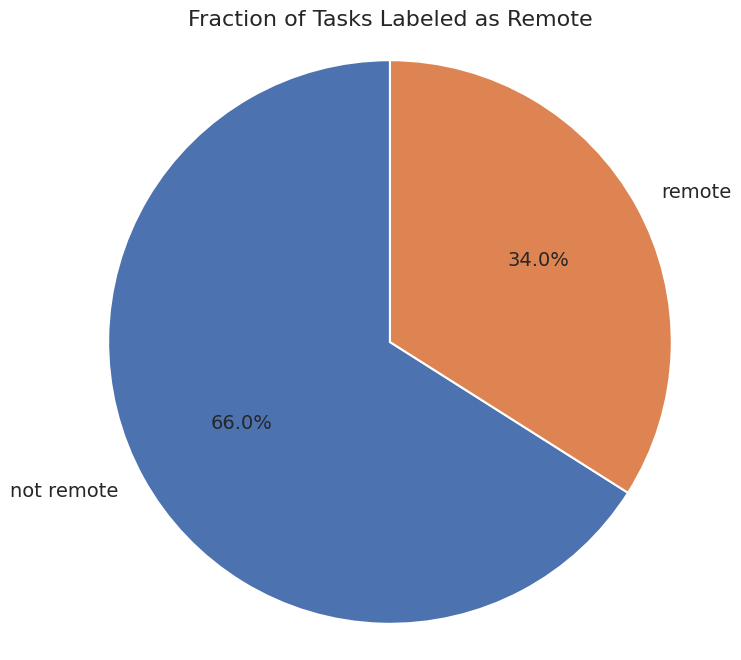

Pie chart exported as remote_tasks_pie_chart.svg


In [ ]:
import matplotlib.pyplot as plt

# Count the number of tasks labeled 'remote' and 'non-remote'
remote_counts = data['Remote'].value_counts()

# Create labels and values for the pie chart
labels = remote_counts.index
sizes = remote_counts.values

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.title('Fraction of Tasks Labeled as Remote', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

# Save the chart as an SVG file
output_file = 'remote_tasks_pie_chart.svg'
plt.savefig(output_file, format='svg')
plt.show()

print(f"Pie chart exported as {output_file}")

In [ ]:
# Install necessary libraries
!pip install pandas matplotlib

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Upload the file manually in Google Colab
from google.colab import files
uploaded = files.upload()

# Load the dataset (replace 'task_data.csv' with the actual file name uploaded)
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

# Ensure numerical columns are properly formatted
data['Importance'] = pd.to_numeric(data['Importance'], errors='coerce')
data['Annual mean wage'] = pd.to_numeric(data['Annual mean wage'], errors='coerce')
data['Total employment'] = pd.to_numeric(data['Total employment'], errors='coerce')

# Filter tasks rated as important at 3.0 or above
filtered_tasks = data[data['Importance'] >= 3.0]

# Calculate the wage bill (annual mean wage * total employment) for each profession
filtered_tasks['Wage Bill'] = filtered_tasks['Annual mean wage'] * filtered_tasks['Total employment']

# Group by profession and sum the wage bill
wage_bill_by_profession = filtered_tasks.groupby('Title').agg(
    {'Wage Bill': 'sum', 'Remote': lambda x: (x == 'remote').sum() / len(x) * 100}
).reset_index()

# Sort by the wage bill and take the top 20 professions
top_20_wage_bill = wage_bill_by_profession.nlargest(20, 'Wage Bill')

# Sort the top 20 professions by the percentage of remote tasks (most to least remote)
top_20_wage_bill_sorted = top_20_wage_bill.sort_values(by='Remote', ascending=False)

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_20_wage_bill_sorted['Title'], top_20_wage_bill_sorted['Remote'], color='skyblue')

# Add labels and title
plt.xlabel('Percentage of Tasks That Can Be Done Remotely')
plt.ylabel('Profession')
plt.title('Top 20 Wage-Bill Professions Sorted by Percentage of Remote Tasks (Most to Least Remote)')

# Add methodology at the bottom with line breaks
methodology_text = (
    "Methodology:\n"
    "- The 'wage bill' for each profession is calculated as (annual mean wage * total employment).\n"
    "- Only tasks rated as important (>=3.0) are included in the analysis.\n"
    "- The top 20 professions by wage bill were selected, and the percentage of remote tasks was calculated for each.\n"
    "- Remote tasks are defined as those explicitly labeled 'remote' in the dataset."
)
plt.figtext(
    0.5, -0.15, methodology_text,
    wrap=True, horizontalalignment='center', fontsize=10
)

# Tight layout to fit everything
plt.tight_layout()

# Save the plot as an SVG file
output_file = "top_20_wage_bill_professions.svg"
plt.savefig(output_file, format='svg')

# Show the plot
plt.show()

# Notify where the file is saved
print(f"The plot has been saved as: {output_file}")